In [1]:
# --- Imports ---
import os
import glob
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from scipy.stats import gamma
from nilearn.glm.first_level import compute_regressor

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting, image

analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'


## 2-Gammas

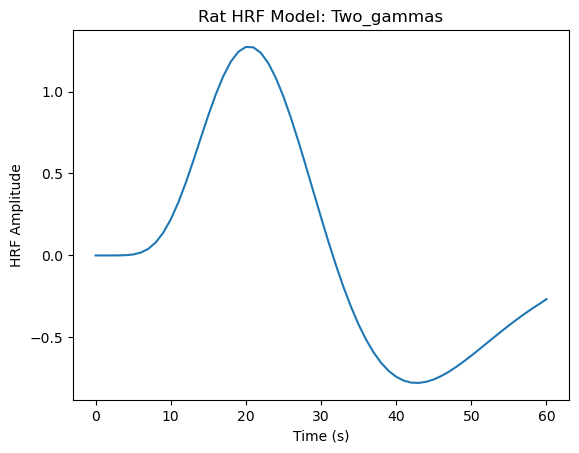

In [8]:
# --- Define Two_gammas --- 

"""
Implement the rat response function model

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Parameters gamma func
    ---------------------
    time_length : stimulation duration in seconds, must be defined before running the function
    tr : in seconds
    h1, h2, l1, and l2 : define the shape and scale parameters
    V = ratio parameter 
    
    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid

""" 

np.printoptions(False)

def Two_gammas(tr, oversampling=16, onset=0.0 ):
    dt = tr / oversampling
    #time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= 1
   
    return response_function


# --- Plot the function with example values ---

time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=Two_gammas,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Two_gammas')
plt.show()

## Peak-Span

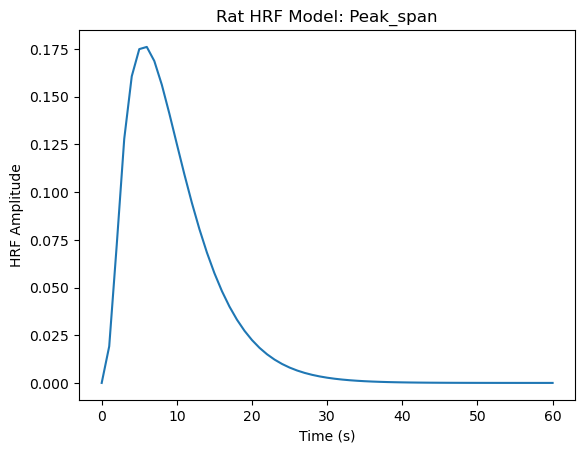

In [2]:
# --- Define Peak_span --- 

"""
Implement the rat response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
"""

def Peak_span(tr, oversampling=16, onset=0.0):
    
    dt = tr / oversampling
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()

    return response_function


# --- Plot the function with example values ---

time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=Peak_span,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Peak_span')
plt.show()

## Design Matrix

In [3]:
# -- Define variables -- 

hrf_function=Peak_span  #Peak_span or Two_gammas
hrf_func='Peak_span'  #Peak_span or Two_gammas

n_stim = 6
onsets= 33, 123, 213, 303, 393, 483
durations= [6] * n_stim
tr = 1.5

trial_type = np.ones_like(onsets)
events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
print(events)
# -- Input data -- 
subj_num= 200201

# subject_path = glob.glob(analysis_folder + f"/sub-0{subj_num}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz")[0]
# subject_path='/project/4180000.19/multirat_stim/rabies/preprocess/sub-0200201_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0200201.session1_split_name_sub-0200201_ses-1_T2w/_run_1/sub-0200201_ses-1_run-1_bold_combined.nii.gz'

#func_img = nib.load(subject_path) 
#n_scans = func_img.shape[3]   
#frame_times = np.arange(n_scans) * tr 
#time_length = 6

   trial_type  onset  duration
0           1     33         6
1           1    123         6
2           1    213         6
3           1    303         6
4           1    393         6
5           1    483         6


### All in nilearn

<Axes: label='conditions', ylabel='scan number'>

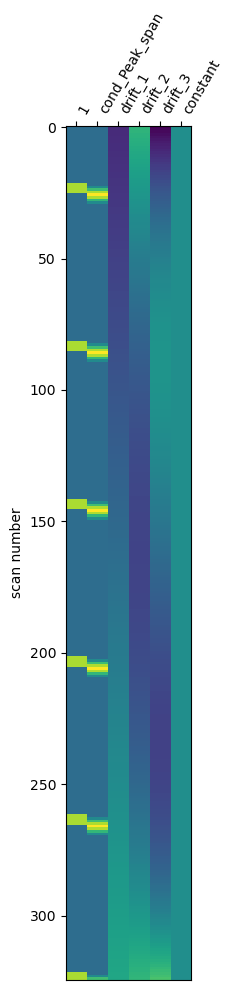

In [4]:
# --- Design Matrix For Rat HRF --- 

subject_path='/project/4180000.19/multirat_stim/rabies/preprocess/sub-0200201_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0200201.session1_split_name_sub-0200201_ses-1_T2w/_run_1/sub-0200201_ses-1_run-1_bold_combined.nii.gz'
func_img = nib.load(subject_path) 

n_scans = func_img.shape[3]   
frame_times = np.arange(n_scans) * tr 
time_length = 6

exp_condition = np.array((onsets, durations, trial_type))
rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)

design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=rat_hrf_model,
                                                add_reg_names=_labels_hrf, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)
    
plot_design_matrix(design_matrix) 
#savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/{hrf_func}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')



### Nifti from jo, model nilearn

<Axes: label='conditions', ylabel='scan number'>

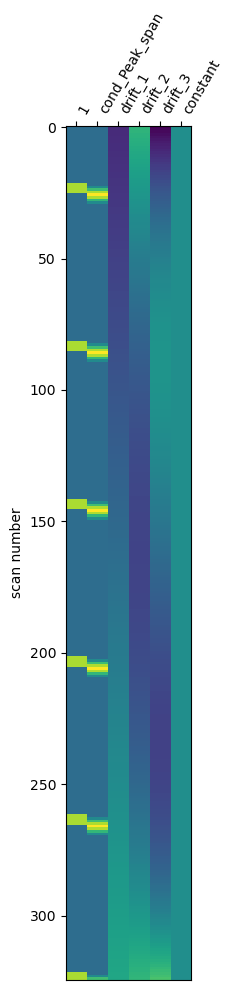

In [5]:
# --- Design Matrix For Rat HRF --- 

subject_path = '/project/4180000.19/multirat_stim/tmp/mc.nii.gz'
func_img = nib.load(subject_path) 

exp_condition = np.array((onsets, durations, trial_type))
rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)

design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=rat_hrf_model,
                                                add_reg_names=_labels_hrf, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)
    
plot_design_matrix(design_matrix) 
#savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/{hrf_func}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')



### All from jo (nifti + peak.txt)

<Axes: label='conditions', ylabel='scan number'>

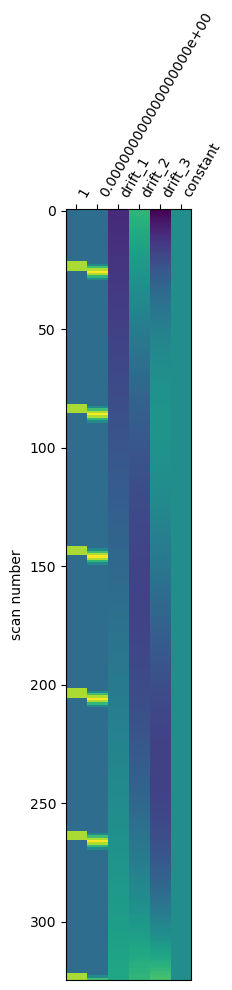

In [6]:
# --- Design Matrix For Rat HRF --- 

subject_path = '/project/4180000.19/multirat_stim/tmp/sub-0200201_ses-1_run-1_bold.nii.gz'
func_img = nib.load(subject_path) 

exp_condition = np.array((onsets, durations, trial_type))

cofounders_path = '/project/4180000.19/multirat_stim/tmp/peak.txt'
cofounders = pd.read_csv(cofounders_path, sep=',')
#Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/Peak_span-matrix_sub-020{ds}00.csv').iloc[:,1]


design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=cofounders,
                                                #add_reg_names=_labels_hrf, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)
    
plot_design_matrix(design_matrix) 
#savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/{hrf_func}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')

## Conpute contrast and plot

/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


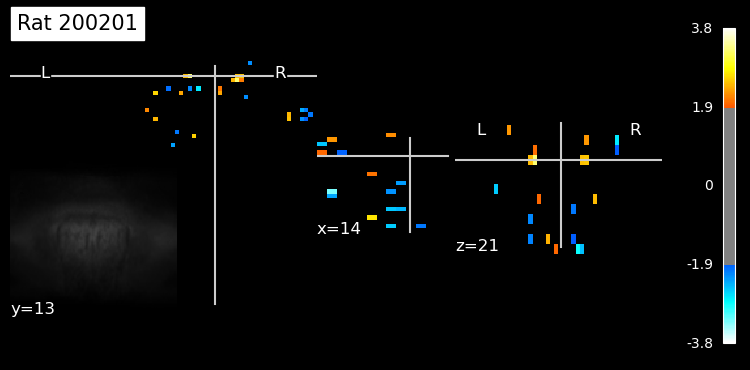

In [7]:
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'

#template_path = '/project/4180000.19/multirat_stim/rabies/BIDS_input/sub-0200201/ses-1/anat/sub-0200201_ses-1_T2w.nii.gz'
#template_path = '/project/4180000.19/multirat_stim/rabies/preprocess/sub-0200201_ses-1/anat_datasink/anat_preproc/_scan_info_subject_id0200201.session1_split_name_sub-0200201_ses-1_T2w/sub-0200201_ses-1_T2w_inho_cor.nii.gz'

fmri_glm = FirstLevelModel(t_r=tr,
                            drift_model='polynomial',
                            signal_scaling=False,
                            smoothing_fwhm=0.45,
                            minimize_memory=False,
                            standardize=True)
    
fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)
        
    # --- Compute contrasts ---
    
n_columns = design_matrix.shape[1]
contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))

statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
# --- Plot and save as nifti file ---
    
plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                        bg_img = template_path, 
                                        cut_coords=(14, 13, 21), 
                                        threshold = 1.9, 
                                        title = 'Rat {}'.format(subj_num))


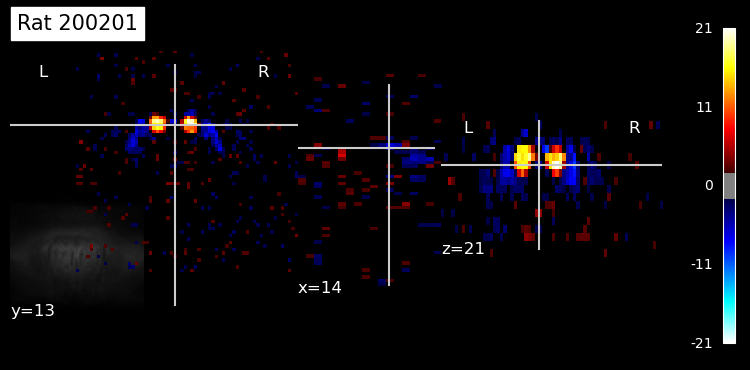

In [8]:
# --- Plot fsl results from J0 --- 

template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
statistical_map = '/project/4180000.19/multirat_stim/tmp/peak_z.nii.gz'
    
 # --- Plot and save as nifti file ---    
plot_stat = plotting.plot_stat_map(statistical_map, 
                                        bg_img = template_path, 
                                        cut_coords=(14, 13, 21), 
                                        threshold = 1.9, 
                                        title = 'Rat {}'.format(subj_num))


## Plot HRFs

(-1.5, 3.0)

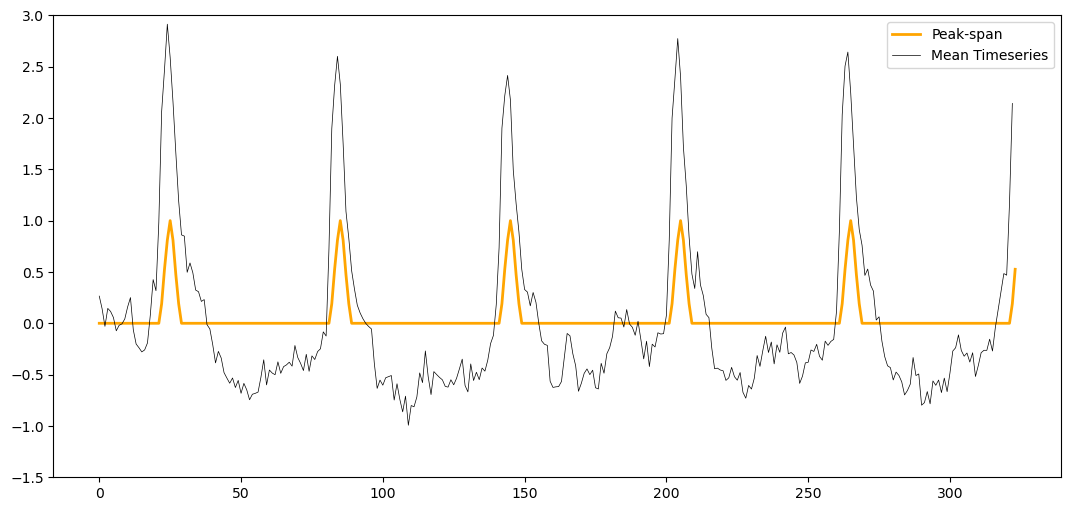

In [17]:
ds='02'
average_timeseries = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/mean_timeseries/mean-timeseries_ds-{ds}.csv')


#Two_gammas_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/Two_gammas-matrix_sub-020{ds}00.csv').iloc[:,1]
Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/Peak_span-matrix_sub-020{ds}01.csv').iloc[:,1]
#glover_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/glover-matrix_sub-020{ds}00.csv').iloc[:,0]
spm_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/spm-matrix_sub-020{ds}01.csv').iloc[:,0]

plt.figure(figsize=(13, 6))

#plt.plot(Two_gammas_model, color='red', linewidth=2, label='Two_gammass')
plt.plot(Peak_span_model, color='orange', linewidth=2, label='Peak-span' )
#plt.plot(glover_model, color='blue', linewidth=1.5, label='Glover' )
#plt.plot(spm_model, color='green', linewidth=1.5, label='Spm' )
plt.plot(average_timeseries, color='black', linewidth=0.5, label='Mean Timeseries')

plt.legend()
plt.ylim(-1.5, 3)

## With motion confounds 

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.75048920e-05]
 [4.86809781e-03]
 [6.05126816e-02]
 [3.15511440e-01]
 [1.00000000e+00]
 [9.99952495e-01]
 [9.95131902e-01]
 [9.39487318e-01]
 [6.84488560e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.75048920e-05]
 [4.86809781e-03]
 [6.05126816e-02]
 [3.15511440e-01]
 [1.00000000e+00]
 [9.99952495e-01]
 [9.95131902e-01]
 [9.39487318e-01]
 [6.84488560e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

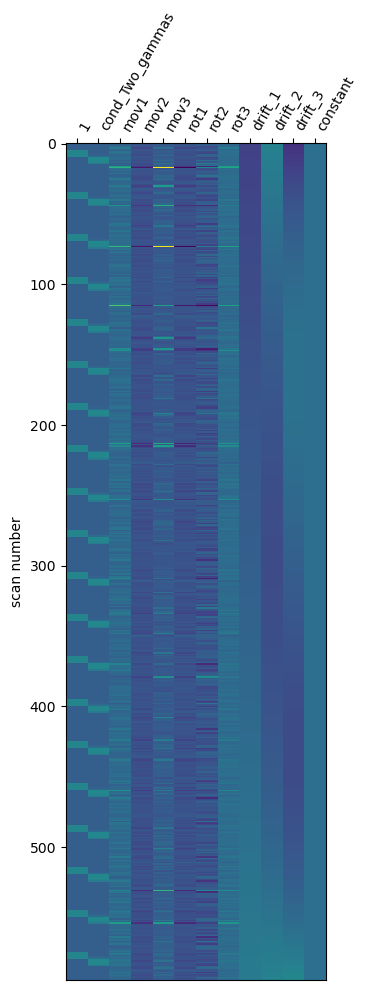

In [26]:
# --- Design Matrix For Rat HRF --- 

subj_num= 200300
ds= '03'
hrf_function=Two_gammas  #Peak_span or Two_gammas
hrf_func='Two_gammas'  #Peak_span or Two_gammas


# - HRF -
exp_condition = np.array((onsets, durations, trial_type))
rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)
print(rat_hrf_model)    

# --- Motion regressors ---

cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num))[0]

cofounders = pd.read_csv(cofounders_path, sep=',')

motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
motion = np.array(cofounders[motion_names])
    
all_regressors = np.column_stack((rat_hrf_model, motion))
all_reg_names = _labels_hrf + motion_names


design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=all_regressors,
                                                add_reg_names=all_reg_names, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)
  
plot_design_matrix(design_matrix) 
savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/co-{hrf_func}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')


(-1.5, 3.0)

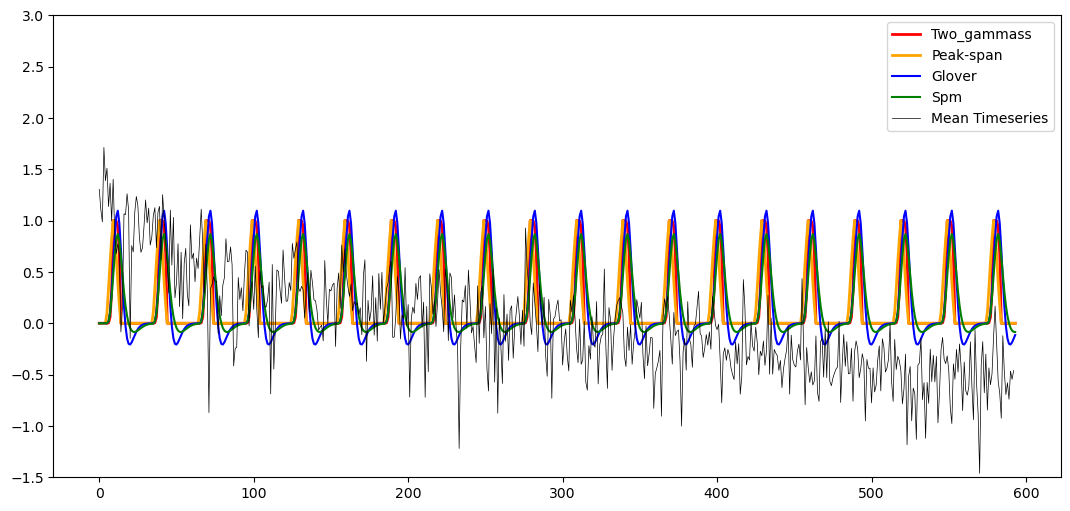

In [28]:
ds='03'
average_timeseries = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/mean_timeseries/mean-timeseries_ds-{ds}.csv')

Two_gammas_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/co-Two_gammas-matrix_sub-020{ds}00.csv').iloc[:,1]
Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/co-Peak_span-matrix_sub-020{ds}00.csv').iloc[:,1]
glover_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/glover-matrix_sub-020{ds}00.csv').iloc[:,0]
spm_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/spm-matrix_sub-020{ds}00.csv').iloc[:,0]

plt.figure(figsize=(13, 6))

plt.plot(Two_gammas_model, color='red', linewidth=2, label='Two_gammass')
plt.plot(Peak_span_model, color='orange', linewidth=2, label='Peak-span' )
plt.plot(glover_model, color='blue', linewidth=1.5, label='Glover' )
plt.plot(spm_model, color='green', linewidth=1.5, label='Spm' )
plt.plot(average_timeseries, color='black', linewidth=0.5, label='Mean Timeseries')

plt.legend()
plt.ylim(-1.5, 3)

(-1.5, 3.0)

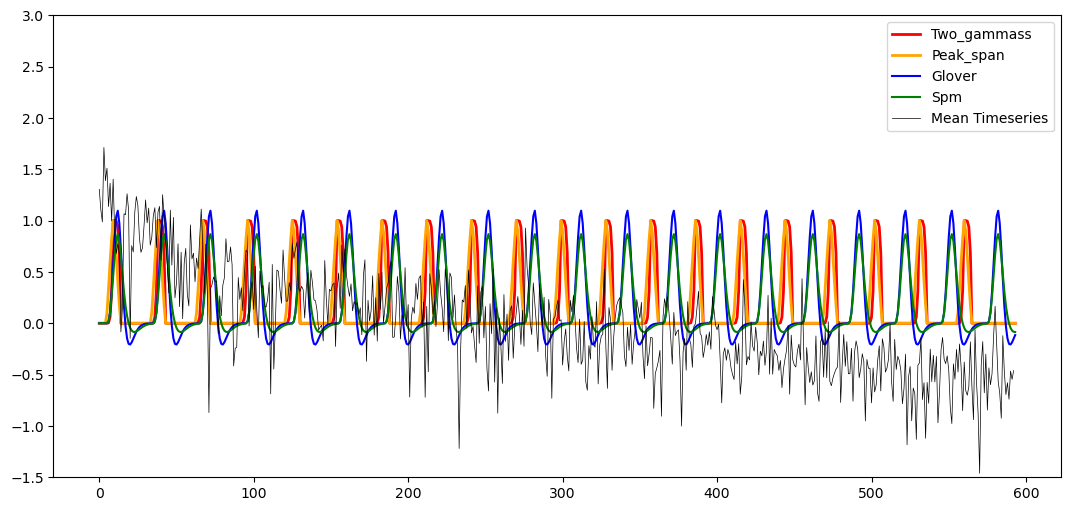

In [23]:
ds='03'
average_timeseries = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/mean_timeseries/mean-timeseries_ds-{ds}.csv')

Two_gammas_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]
Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]
glover_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]
spm_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]

plt.figure(figsize=(13, 6))

plt.plot(Two_gammas_model, color='red', linewidth=2, label='Two_gammass')
plt.plot(Peak_span_model, color='orange', linewidth=2, label='Peak_span' )
plt.plot(glover_model, color='blue', linewidth=1.5, label='Glover' )
plt.plot(spm_model, color='green', linewidth=1.5, label='Spm' )
plt.plot(average_timeseries, color='black', linewidth=0.5, label='Mean Timeseries')

plt.legend()
plt.ylim(-1.5, 3)

In [ ]:
hrf_model = 'spm' # glover or spm

# --- Design Matrix For Rat HRF --- 
design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=hrf_model,  
                                                high_pass=0.01)
    
plot_design_matrix(design_matrix) 
print(f'Number of time points in Peak_00: {len(design_matrix.iloc[:,1])}')
savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/{hrf_model}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')